In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
data =pd.read_csv("decomposition.csv", sep=",")
# Label columns
data.columns = ['date', 'y']
# Set dates as index
data = data.set_index(pd.to_datetime(data.iloc[:,0])).drop('date', axis=1)
data.head()

,y
date,
2013-01-01,16.650798
2013-01-02,6.651429
2013-01-03,16.537404
2013-01-04,19.662590
2013-01-05,6.632995


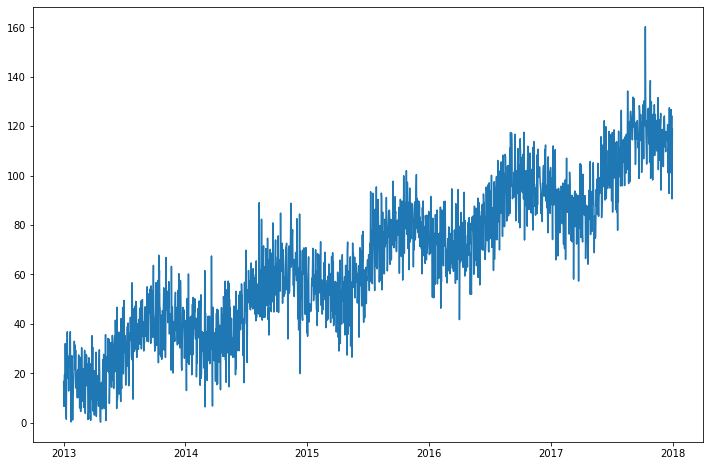

In [3]:
plt.figure(figsize=(12,8),edgecolor='orange',)
plt.plot(data['y'])
plt.show()

In [4]:
train = data.loc[data.index < '2017-01-01']
test = data.loc[data.index > '2017-01-01']
# Monthly cycle during the year
df_year = pd.DataFrame({"y": train.y.resample("M").sum()})
df_year['mva'] = df_year.y.rolling(center=True, window=12).mean()

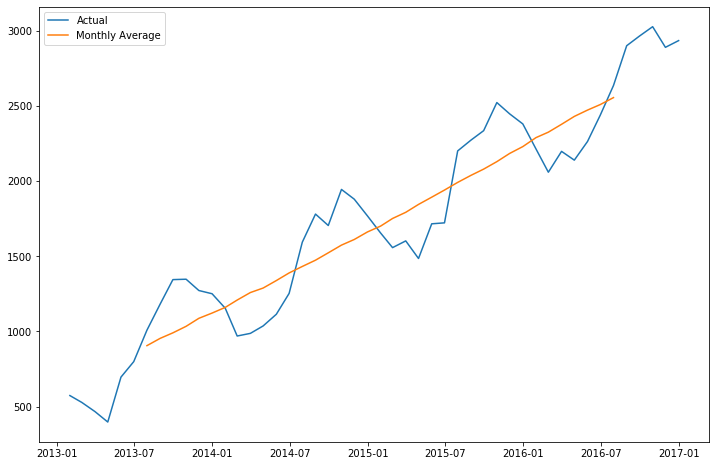

In [5]:
plt.figure(figsize=(12,8))
plt.plot(df_year['y'], label='Actual')
plt.plot(df_year['mva'], label='Monthly Average')
plt.legend(loc='best')
plt.show()


In [6]:
df_year['sr'] = df_year['y'] / df_year['mva']

# Add month numbers
df_year['month'] = df_year.index.month
# Extract all January data for example
df_ = df_year.loc[df_year['month']==1]
#USI1=SR1+SR2+SR33=0.995012+0.972768+0.9669513
df_ = df_year.groupby('month').agg({
        'sr': 'mean'})## Average each month 

df_.reset_index(inplace=True)
df_.columns = ['month', 'usi']

# Combine with main data frame
df_year = pd.merge(df_year, df_, on='month', right_index=True).sort_index()


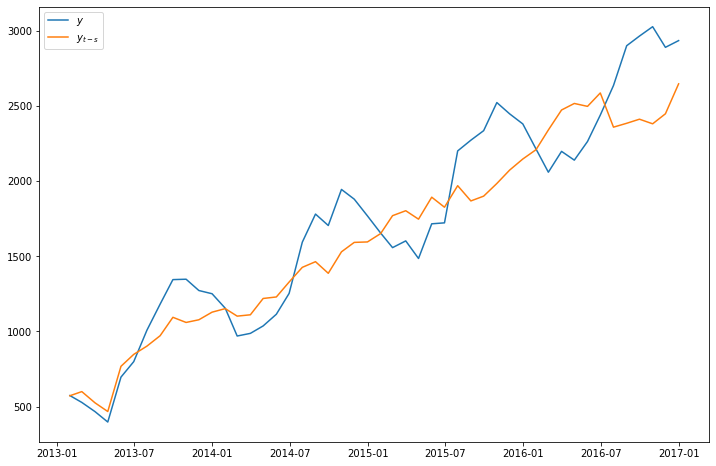

In [8]:
df_year['asi'] = df_['usi'].mean() * df_year['usi']
df_year['y_t-s'] = df_year['y'] / df_year['asi']#de-seasonalized values ( yt−s ):
plt.figure(figsize=(12,8))
plt.plot(df_year['y'], label='$y$')
plt.plot(df_year['y_t-s'], label='$y_{t-s}$')
plt.legend(loc='best')
plt.show()#the large cycles in the sales have been smoothed out and lessened by our de-seasonalizing efforts

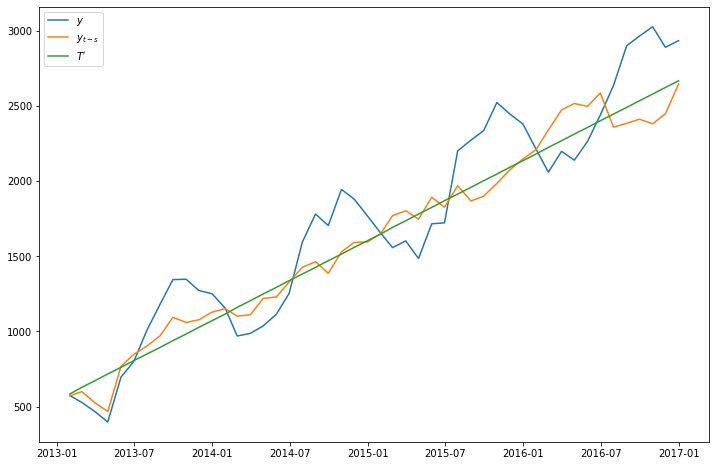

In [9]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(normalize=False, fit_intercept=True)
y_t_s = np.atleast_2d(df_year['y_t-s'].values).T
x = np.atleast_2d(np.linspace(0, len(df_year) - 1, len(df_year))).T
lm.fit(x, y_t_s)
df_year['trend'] = lm.predict(x)
# Plot actual data, de-seasonalized data, and the trend
plt.figure(figsize=(12,8))
plt.plot(df_year['y'], label='$y$')
plt.plot(df_year['y_t-s'], label='$y_{t-s}$')
plt.plot(df_year['trend'], label="$T'$")
plt.legend(loc='best')
plt.show()

In [10]:
df_year['noise'] = (df_year['y'] / (df_year['asi'] * df_year['trend'])).mean()
df_year.head()

,y,mva,sr,month,usi,asi,y_t-s,trend,noise
date,,,,,,,,,
2013-01-31,573.380450,NaN,NaN,1,0.978244,1.002169,572.139436,583.890406,0.996968
2013-02-28,527.714935,NaN,NaN,2,0.858922,0.879929,599.724526,628.235745,0.996968
2013-03-31,466.634457,NaN,NaN,3,0.867474,0.888690,525.081157,672.581085,0.996968
2013-04-30,397.257325,NaN,NaN,4,0.829878,0.850175,467.265296,716.926424,0.996968
2013-05-31,696.166346,NaN,NaN,5,0.884812,0.906452,768.012088,761.271763,0.996968


In [11]:
test_year = pd.DataFrame({"y": test.y.resample("M").sum()})
test_year['month'] = test_year.index.month

# get index for trend regression
x_test = np.linspace(len(df_year), len(df_year) + 
                     len(test_year) - 1,
                    len(test_year)).reshape(-1,1)
df_test = pd.merge(test_year, df_year[['month', 'asi', 'noise']], 
                   on='month', 
                   right_index=True).sort_index().drop_duplicates()
df_test['trend'] = lm.predict(x_test)
df_test['forecast'] = df_test['asi'] * df_test['noise'] * df_test['trend']
df_test

,y,month,asi,noise,trend,forecast
date,,,,,,
2017-01-31,2666.945899,1,1.002169,0.996968,2712.466680,2710.108876
2017-02-28,2458.970713,2,0.879929,0.996968,2756.812019,2418.444124
2017-03-31,2589.872089,3,0.888690,0.996968,2801.157358,2481.813866
2017-04-30,2563.687815,4,0.850175,0.996968,2845.502697,2411.841242
2017-05-31,2797.599595,5,0.906452,0.996968,2889.848036,2611.567792
2017-06-30,3073.134071,6,0.943053,0.996968,2934.193375,2758.710156
2017-07-31,3191.893059,7,1.117472,0.996968,2978.538714,3318.341706
2017-08-31,3473.627714,8,1.216348,0.996968,3022.884053,3665.732491
2017-09-30,3516.377677,9,1.229261,0.996968,3067.229392,3758.994820


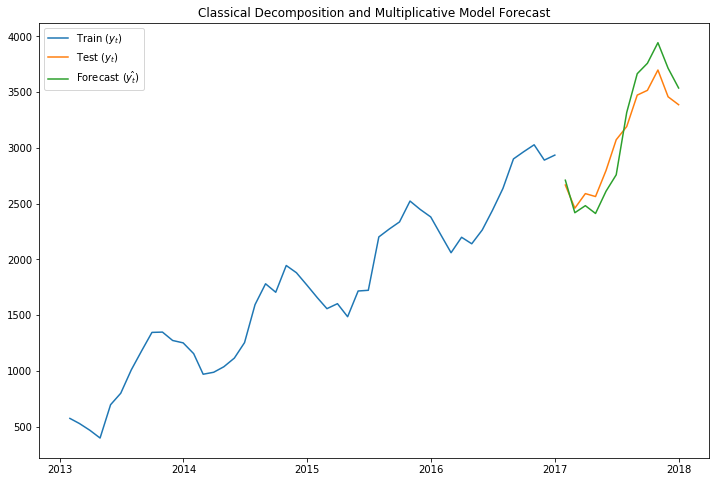

In [12]:
plt.figure(figsize=(12,8))
plt.plot(df_year['y'], label='Train ($y_t$)')
plt.plot(df_test['y'], label='Test ($y_t$)')
plt.plot(df_test['forecast'], label='Forecast ($\hat{y_t}$)')
plt.legend(loc='best')
plt.title("Classical Decomposition and Multiplicative Model Forecast")
plt.show()


In [11]:
evaluation = df_test.copy()
evaluation['error'] = evaluation['y'] - evaluation['forecast']

evaluation.insert(0, 'series', 1) # insert value to groupby
evaluation.groupby('series').agg({
        'y' : 'sum',
        'forecast' : 'sum',
        'error': {
            'total_error' : 'sum',
            'percentage_error' : lambda x: round(100 * np.sum(x) / np.sum(evaluation['y'])),
            'mae': lambda x: np.mean(np.abs(x)),
            'rmse': lambda x: np.sqrt(np.mean(x ** 2)),
            'mape': lambda x: 100 * np.sum(np.abs(x)) / np.sum(evaluation['y'])
        }}).apply(np.round, axis=1)

C:\Users\KIIT\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


y forecast       error                                    
            sum      sum total_error percentage_error    mae   rmse mape
series                                                                  
1       36877.0  37331.0      -454.0             -1.0  171.0  190.0  6.0

NameError: name 'y' is not defined